<a href="https://colab.research.google.com/github/erinijapranckeviciene/MF54609_18981_1_20241/blob/main/A_Geron_book_Chapter_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GAN Generative adversarial network

Example on Fashion MNIST dataset p.661

..."Let’s go ahead and build a simple GAN for Fashion MNIST.
First, we need to build the generator and the discriminator. The generator is similar
to an autoencoder’s decoder, and the discriminator is a regular binary classifier:
it takes an image as input and ends with a Dense layer containing a single unit
and using the sigmoid activation function. For the second phase of each training
iteration, we also need the full GAN model containing the generator followed by the
discriminator:"...

In [2]:
import keras as keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Textbook does not have input layer

codings_size = 30
batch_size = 32


Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
# Input and shape were required
keras.layers.InputLayer((codings_size,) ), #added - but waht it does?
# The above line was added to the textbook code

Dense(100, activation="relu", kernel_initializer="he_normal"),
Dense(150, activation="relu", kernel_initializer="he_normal"),
Dense(28 * 28, activation="sigmoid"),
tf.keras.layers.Reshape([28, 28])
])

discriminator = tf.keras.Sequential([
tf.keras.layers.Flatten(),
Dense(150, activation="relu", kernel_initializer="he_normal"),
Dense(100, activation="relu", kernel_initializer="he_normal"),
Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])
gan.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 28, 28)              │         136,634 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         132,951 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 269,585 (1.03 MB)

 Trainable params: 269,585 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

..."Next, we need to compile these models. As the discriminator is a binary classifier,
we can naturally use the binary cross-entropy loss. The gan model is also a binary
classifier, so it can use the binary cross-entropy loss as well. However, the generator
will only be trained through the gan model, so we do not need to compile it at all.
Importantly, the discriminator should not be trained during the second phase, so we
make it non-trainable before compiling the gan model:"...

In [3]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

..."Since the training loop is unusual, we cannot use the regular fit() method. Instead,
we will write a custom training loop. For this, we first need to create a Dataset to
iterate through the images:"...

In [4]:
# The code is added to this snippet in the textbook
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
# The dataset import is added

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1000)
print(X_train.shape)
print("dataset shuffle")
print(dataset)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
print("dataset prefetch")
print(dataset)
print(len(dataset))

(60000, 28, 28)
dataset shuffle
<_ShuffleDataset element_spec=TensorSpec(shape=(28, 28), dtype=tf.float32, name=None)>
dataset prefetch
<_PrefetchDataset element_spec=TensorSpec(shape=(32, 28, 28), dtype=tf.float32, name=None)>
1875


..."We are now ready to write the training loop. Let’s wrap it in a train_gan() function.

As discussed earlier, you can see the two phases at each iteration:
  - In phase one we feed Gaussian noise to the generator to produce fake images,
and we complete this batch by concatenating an equal number of real images.
The targets y1 are set to 0 for fake images and 1 for real images. Then we train
the discriminator on this batch. Remember that the discriminator is trainable in
this phase, but we are not touching the generator.
  - In phase two, we feed the GAN some Gaussian noise. Its generator will start by
producing fake images, then the discriminator will try to guess whether these
images are fake or real. In this phase, we are trying to improve the generator,
which means that we want the discriminator to fail: this is why the targets y2 are
all set to 1, although the images are fake. In this phase, the discriminator is not
trainable, so the only part of the gan model that will improve is the generator.

In [5]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1, n_epochs))
    batch_count = 0
    for X_batch in dataset:
    # phase 1 - training the discriminator
      batch_count += 1
      if batch_count % 500 == 0:
        print(batch_count)
      noise = tf.random.normal(shape=[batch_size, codings_size])

      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.train_on_batch(X_fake_and_real, y1)
      # phase 2 - training the generator
      noise = tf.random.normal(shape=[batch_size, codings_size])

      y2 = tf.constant([[1.]] * batch_size)
      gan.train_on_batch(noise, y2)

### **Takes a lot of time to train !**
Therefore, it is only one epoch.

In [6]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Epoch 1/1


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


500
1000
1500


..."That’s it! After training, you can randomly sample some codings from a Gaussian
distribution, and feed them to the generator to produce new images:"...

In [7]:
codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


..."If you display the generated images (see Figure 17-15), you will see that at the end of
the first epoch, they already start to look like (very noisy) Fashion MNIST images."...

### **After one epoch it is only noise **

In [12]:
print(generated_images.shape)


(32, 28, 28)


In [15]:
generated_images[0].shape

(28, 28)

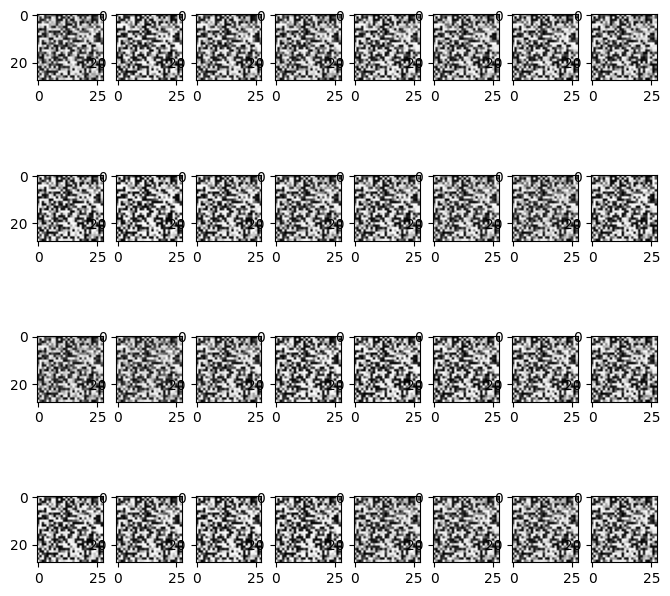

In [21]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4,8, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(generated_images[i], cmap='gray')

### Here is a code from Keras that you can try, but it is somehow complicated

[https://keras.io/examples/generative/conditional_gan/](https://keras.io/examples/generative/conditional_gan/)